In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
spark = SparkSession.builder.appName('xxxx').getOrCreate()

In [4]:
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



#### Aim
The aim is to predict whether the client will subscribe to a term deposit.
#### Features
- categorical (9): job, marital, education, default, housing, loan, contact, month, poutcome
- numeric (7): age, balance, day, duration, campaign, pdays, previous

In [5]:
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

#### EDA
Checking whether class are balanced

In [6]:
df.toPandas().groupby(['deposit']).size()

deposit
no     5873
yes    5289
dtype: int64

In [8]:
df.toPandas().describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


#### Correlations

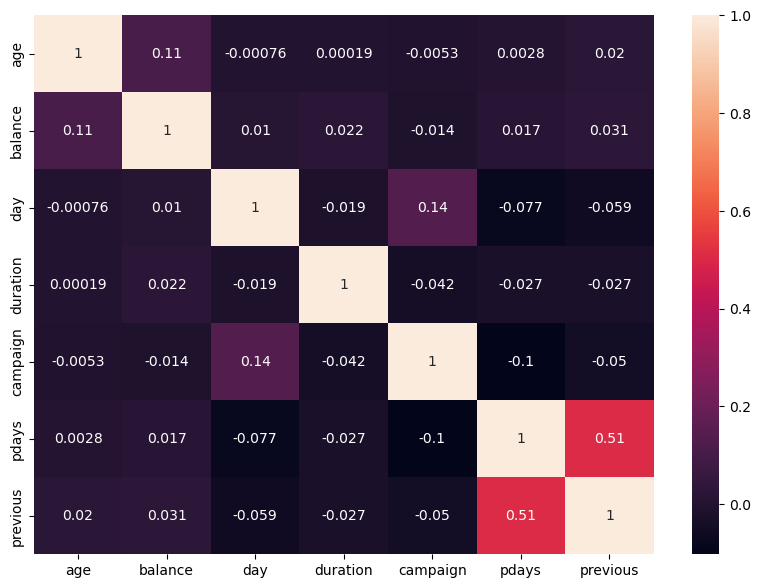

In [13]:
fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(df.toPandas().dropna().corr(numeric_only=True), annot=True)
plt.show()

There are not any high correlation, so we will keep all features. However, *day* and *month* will not be very useful, thus we will drop them.

In [17]:
df = df.drop('day','month')
cols = df.columns

#### Prepare data

In [25]:
all_stages = []
categor_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for categor_col in categor_cols:
    stringIndexer = StringIndexer(inputCol = categor_col, outputCol = categor_col + '_idx')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categor_col + "_class_vec"])
    all_stages += [stringIndexer, encoder]


label_string_idx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
all_stages += [label_string_idx]

numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assembler_inputs = [c + "_class_vec" for c in categor_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
all_stages += [assembler]

In [26]:
df2 = Pipeline(stages=all_stages).fit(df).transform(df)

In [28]:
df2.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+-------+--------------+-----------+-----------------+-------------+-------------------+-----------+-----------------+-----------+-----------------+--------+--------------+-----------+-----------------+------------+------------------+-----+--------------------+
|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|job_idx| job_class_vec|marital_idx|marital_class_vec|education_idx|education_class_vec|default_idx|default_class_vec|housing_idx|housing_class_vec|loan_idx|loan_class_vec|contact_idx|contact_class_vec|poutcome_idx|poutcome_class_vec|label|            features|
+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+-------+--------------+-----------+-----------------+-------------+-------------------+-----------+----------

In [34]:
selected_cols = cols + ['label','features']
df = df2.select(selected_cols)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [32]:
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+-----+--------------------+
|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|label|            features|
+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+-----+--------------------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0| unknown|    yes|  1.0|(30,[3,11,13,16,1...|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0| unknown|    yes|  1.0|(30,[3,11,13,16,1...|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0| unknown|    yes|  1.0|(30,[2,11,13,16,1...|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|     579|       1|   

#### Splitting data

In [52]:
train, test = df.randomSplit([0.7, 0.3], seed = 1234)

In [53]:
str(train.count()), str(test.count())

('7828', '3334')

#### Logistic Regression

In [54]:
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
log_reg_model = log_reg.fit(train)

In [55]:
log_reg_preds = log_reg_model.transform(test)

In [58]:
log_reg_preds.select('label','age','job','education', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+---+-------+---------+--------------------+----------+--------------------+
|label|age|    job|education|       rawPrediction|prediction|         probability|
+-----+---+-------+---------+--------------------+----------+--------------------+
|  1.0| 18|student|  primary|[-2.8990524205661...|       1.0|[0.05220042519505...|
|  1.0| 18|student|  primary|[-0.5848004573045...|       1.0|[0.35782875812645...|
|  1.0| 18|student|  unknown|[-2.4463479494043...|       1.0|[0.07970602710646...|
|  0.0| 20| admin.|secondary|[0.96251092861643...|       0.0|[0.72362425310875...|
|  1.0| 20|student|  unknown|[-1.3955739986110...|       1.0|[0.19851939048208...|
|  0.0| 20|student|  primary|[-0.0982141935781...|       1.0|[0.47546616960320...|
|  0.0| 20|student|  primary|[-1.2082113962821...|       1.0|[0.23001767676401...|
|  1.0| 20|student|  primary|[-0.2244954229397...|       1.0|[0.44411067409966...|
|  1.0| 20|student|secondary|[1.39313503639226...|       0.0|[0.80109226224084...|
|  1

In [72]:
log_reg_eval = BinaryClassificationEvaluator()
print(f"Area Under ROC Curve: {log_reg_eval.evaluate(log_reg_preds)}")

Area Under ROC Curve: 0.8820935804049177


#### Decision Tree Classifier

In [61]:
dec_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dec_tree_model = dec_tree.fit(train)

In [62]:
dec_tree_preds = dec_tree_model.transform(test)

In [63]:
dec_tree_preds.select('label','age','job','education', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+---+-------+---------+--------------+----------+--------------------+
|label|age|    job|education| rawPrediction|prediction|         probability|
+-----+---+-------+---------+--------------+----------+--------------------+
|  1.0| 18|student|  primary|[901.0,1320.0]|       1.0|[0.40567312021611...|
|  1.0| 18|student|  primary|[901.0,1320.0]|       1.0|[0.40567312021611...|
|  1.0| 18|student|  unknown|  [27.0,109.0]|       1.0|[0.19852941176470...|
|  0.0| 20| admin.|secondary|[2199.0,338.0]|       0.0|[0.86677177769018...|
|  1.0| 20|student|  unknown|[901.0,1320.0]|       1.0|[0.40567312021611...|
|  0.0| 20|student|  primary|[2199.0,338.0]|       0.0|[0.86677177769018...|
|  0.0| 20|student|  primary|[901.0,1320.0]|       1.0|[0.40567312021611...|
|  1.0| 20|student|  primary|[901.0,1320.0]|       1.0|[0.40567312021611...|
|  1.0| 20|student|secondary|[2199.0,338.0]|       0.0|[0.86677177769018...|
|  1.0| 20|student|secondary|[901.0,1320.0]|       1.0|[0.40567312021611...|

In [73]:
dec_tree_eval = BinaryClassificationEvaluator()
print(f"Area Under ROC Curve: {dec_tree_eval.evaluate(dec_tree_preds)}")

Area Under ROC Curve: 0.783849384099557


#### Random forest Classifier

In [65]:
random_f = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
random_f_model = random_f.fit(train)

In [66]:
random_f_preds = random_f_model.transform(test)

In [67]:
random_f_preds.select('label','age','job','education', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+---+-------+---------+--------------------+----------+--------------------+
|label|age|    job|education|       rawPrediction|prediction|         probability|
+-----+---+-------+---------+--------------------+----------+--------------------+
|  1.0| 18|student|  primary|[2.66270320215190...|       1.0|[0.13313516010759...|
|  1.0| 18|student|  primary|[9.11031947825185...|       1.0|[0.45551597391259...|
|  1.0| 18|student|  unknown|[5.88523734113993...|       1.0|[0.29426186705699...|
|  0.0| 20| admin.|secondary|[13.2124168773513...|       0.0|[0.66062084386756...|
|  1.0| 20|student|  unknown|[5.24090947294857...|       1.0|[0.26204547364742...|
|  0.0| 20|student|  primary|[9.06494886348601...|       1.0|[0.45324744317430...|
|  0.0| 20|student|  primary|[6.51621764962304...|       1.0|[0.32581088248115...|
|  1.0| 20|student|  primary|[9.62645769418626...|       1.0|[0.48132288470931...|
|  1.0| 20|student|secondary|[16.8638777735919...|       0.0|[0.84319388867959...|
|  1

In [74]:
random_f_eval = BinaryClassificationEvaluator()
print(f"Area Under ROC Curve: {random_f_eval.evaluate(random_f_preds)}")

Area Under ROC Curve: 0.8726102726398993
